# Пробуем метод анализа от исследователей Яндекса

##### Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR)

При этом метод сам по себе очень прост. Что это за метрика такая?

* Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
* Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
* После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

#### Задача
1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [9]:
#Получаем данные и смотрим на размер групп

import pandahouse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
                    'database':'simulator_20220520',
                    'user':'student', 
                    'password':'dpo_python_2020'
}

q = '''SELECT user_id, 
            exp_group,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM {db}.feed_actions
        where toDate(time) >= '2022-04-24' and toDate(time) <= '2022-04-30'
        group by user_id, exp_group
        '''

df = pandahouse.read_clickhouse(q, connection=connection)
df.head(2)

,user_id,exp_group,likes,views,ctr
0,115383,3,9,30,0.30000
1,18392,1,7,32,0.21875


Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

In [10]:
df_group_03 = df.query('exp_group == 0 or exp_group == 3')
df_group_12 = df.query('exp_group == 1 or exp_group == 2')

In [17]:
ctr_control_1_2 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
ctr_control_0_3 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()

Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

In [21]:
df_group_03['linearized_likes'] = df_group_03.likes - ctr_control_0_3 * df_group_03.views
df_group_12['linearized_likes'] = df_group_12.likes - ctr_control_1_2 * df_group_12.views

/tmp/ipykernel_290/1266781387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group_03['linearized_likes'] = df_group_03.likes - ctr_control_0_3 * df_group_03.views
/tmp/ipykernel_290/1266781387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group_12['linearized_likes'] = df_group_12.likes - ctr_control_1_2 * df_group_12.views


После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

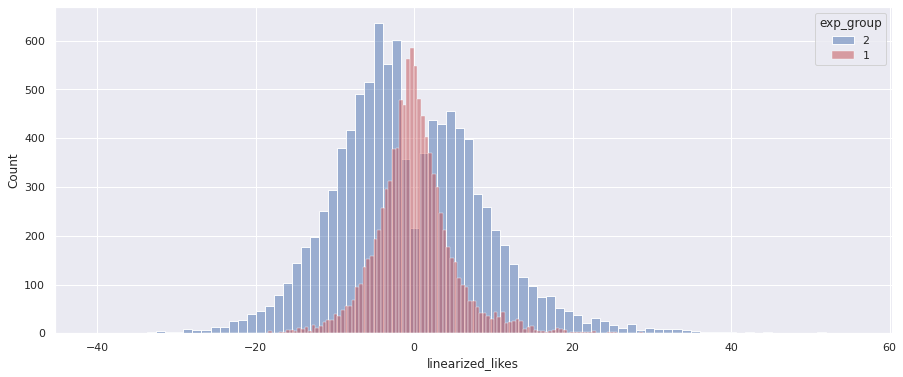

In [22]:
#Строим график для метрики linearized_likes в 1 и 2 группах
sns.set(rc = {'figure.figsize':(15,6)})
sns.histplot(data = df_group_12[df_group_12.exp_group == 2], x = 'linearized_likes', kde = False, color = 'b', alpha = 0.5, label = '2')
sns.histplot(data = df_group_12[df_group_12.exp_group == 1], x = 'linearized_likes', kde = False, color = 'r', alpha = 0.5, label = '1')
plt.legend(title = 'exp_group')

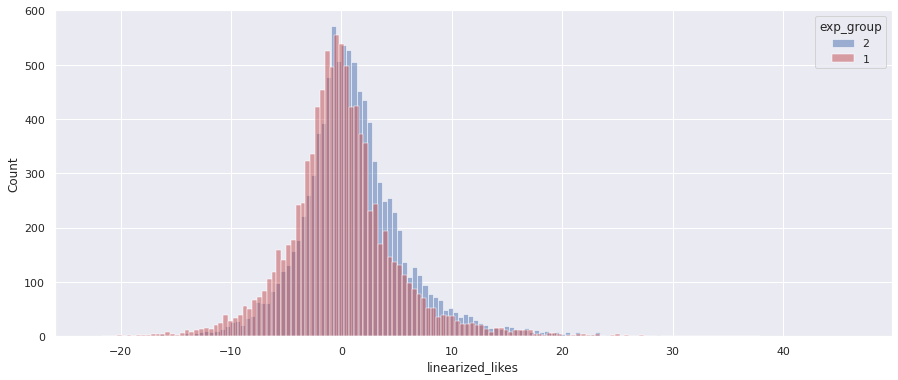

In [39]:
#Строим график для метрики linearized_likes в 0 и 3 группах
sns.histplot(data = df_group_03[df_group_03.exp_group == 3], x = 'linearized_likes', kde = False, color = 'b', alpha = 0.5, label = '2')
sns.histplot(data = df_group_03[df_group_03.exp_group == 0], x = 'linearized_likes', kde = False, color = 'r', alpha = 0.5, label = '1')
plt.legend(title = 'exp_group')

In [24]:
#Проводим t-тест между группами 0-3
stats.ttest_ind(df_group_03[df_group_03.exp_group == 0].linearized_likes,
               df_group_03[df_group_03.exp_group == 3].linearized_likes,
               equal_var = False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [40]:
#Проводим t-тест между группами 1-2
stats.ttest_ind(df_group_12[df_group_12.exp_group == 1].linearized_likes,
               df_group_12[df_group_12.exp_group == 2].linearized_likes,
               equal_var = False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

# Выводы

Мы провели t-тест по метрике линеаризованных лайков и будем сравнивать его c t-тестом по поюзерной метрике CTR. Выведем все результаты тестов:
##### Поюзерная метрика CTR:
- P-value = 1.055849414662529e-43 в группах 0-3 
- P-value = 0.4780623130874935 в группах 1-2

##### Метрика линеаризованных лайков:
- P-value = 5.4914249479690016e-52 в группах 0-3
- P-value = 9.439432187037644e-10  в группах 1-2

Перед нами стояли 2 вопроса, изменяются ли в меньшую сторону p-value при использовании метрика линеаризованных лайков для группы 0-3 и группы 1-2? По вышеуказанным данным можно с уверенностью сказать, что при методе от яндекса p-value изменился в меньшую сторону и в группах 0-3 и 1-2.

Если быть уж совсем точным в цифрах, то разница p-value между CTR и линеаризованными лайками составила:
- 0-3: 0.47806231214355027
- 1-2: 1.0558494091711042e-43

P.S. Данные p-value для метрики CTR взял из прошлого задания, чтобы не засорять данный расчёт